In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

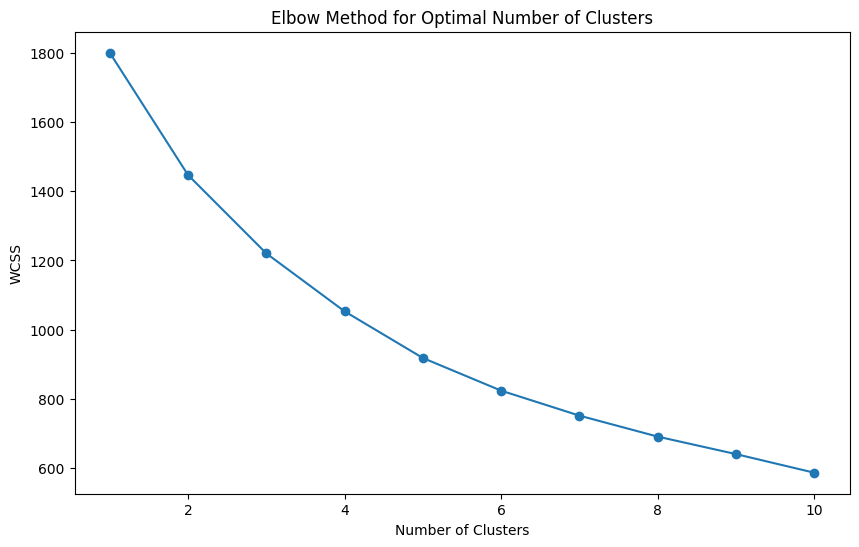

General Technology Industry Benchmark Categories:
   Total Energy Consumption  Total Water Consumption  Total Waste Generated  \
0               4500.208927              1169.707642             636.664835   
1               8031.548479              2671.431236             384.436439   
2               3471.442186              3773.267686             465.744424   

   GHG_Emissions_PCA  Cluster  
0         -53.203240        0  
1          36.136573        1  
2           6.730493        2  
Feature Weights for ESG Performance Scoring System:
Total Water Consumption     0.565474
GHG_Emissions_PCA           0.087066
Total Energy Consumption   -0.134838
Total Waste Generated      -0.166877
dtype: float64


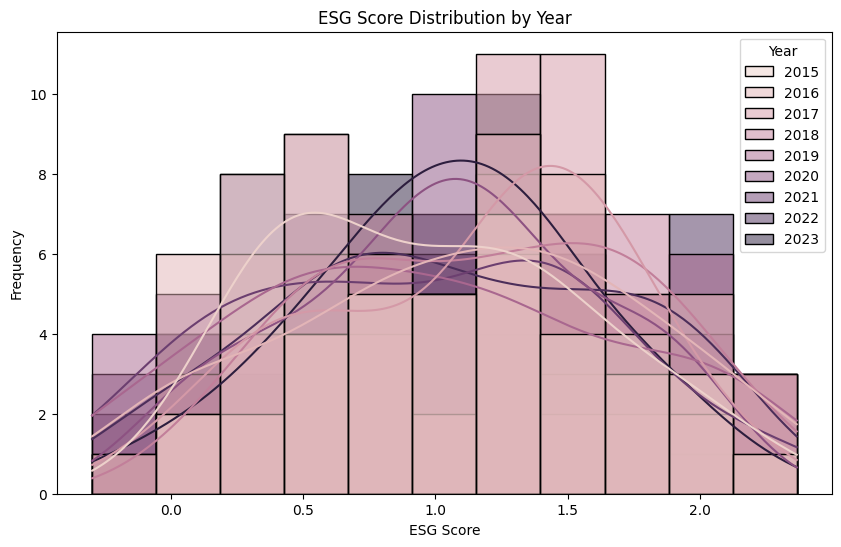

  Company Name  Year  Cluster Performance Category  predicted_score
0    Company_1  2015        2                 Good         1.374003
1    Company_1  2016        1              Average         0.721749
2    Company_1  2017        0                 Poor         0.743961
3    Company_1  2018        2                 Good         1.969090
4    Company_1  2019        2                 Good         1.942816


In [2]:
# Step 1: Load Data
file_path = '../ChatGPT-simulate data/Simulate-E-data-9 years.xlsx'
data = pd.read_excel(file_path)

# Step 2: Data Preprocessing
# Drop non-numeric columns that are not needed for imputation
company_names = data['Company Name']  # Assuming the first column is 'Company Name'
data_numeric = data.drop(columns=['Company Name', 'Year', 'GHG Emissions (Total)'])

# Handle missing values(Implement techniques to handle missing data and ensure fair comparisons across companies.)
imputer = SimpleImputer(strategy='median')
data_imputed = pd.DataFrame(imputer.fit_transform(data_numeric), columns=data_numeric.columns)

# Step 3: PCA on GHG Emissions (Scope 1, Scope 2, Scope 3)
pca_columns = ['GHG Emissions (Scope 1)', 'GHG Emissions (Scope 2)', 'GHG Emissions (Scope 3)']
pca = PCA(n_components=1)
data_imputed['GHG_Emissions_PCA'] = pca.fit_transform(data_imputed[pca_columns])

# Drop original GHG emissions columns
data_imputed = data_imputed.drop(columns=pca_columns)

# Step 4: Standardize Data
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_imputed), columns=data_imputed.columns)

# Step 5: Apply KMeans Clustering
# Determine the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Step 6: Train KMeans Model with Optimal Number of Clusters
# Assuming the optimal number of clusters is 3 based on the elbow plot
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
data['Cluster'] = kmeans.fit_predict(data_scaled)

# Step 7: Create General Industry Benchmark
# Since all companies are in the technology industry, create benchmark categories based on cluster assignments
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=data_imputed.columns)
cluster_centers['Cluster'] = range(optimal_clusters)

# Categorize companies based on their cluster
def categorize_performance(cluster):
    if cluster == cluster_centers['Cluster'].idxmax():
        return 'Good'
    elif cluster == cluster_centers['Cluster'].idxmin():
        return 'Poor'
    else:
        return 'Average'

data['Performance Category'] = data['Cluster'].apply(categorize_performance)

print("General Technology Industry Benchmark Categories:")
print(cluster_centers)

# Step 8: Create Scoring System
# Use a Linear Regression model to calculate an ESG performance score
X = data_scaled
reg = LinearRegression()
reg.fit(X, data['Cluster'])

# Predicted ESG performance score
data['predicted_score'] = reg.predict(X)

# Get feature importance (coefficients)
feature_weights = pd.Series(reg.coef_, index=data_imputed.columns).sort_values(ascending=False)
print("Feature Weights for ESG Performance Scoring System:")
print(feature_weights)

# Step 9: Visualization of ESG Scores by Year
plt.figure(figsize=(10, 6))
sns.histplot(data, x='predicted_score', hue='Year', kde=True)
plt.title('ESG Score Distribution by Year')
plt.xlabel('ESG Score')
plt.ylabel('Frequency')
plt.show()

# Step 10: Save Results
data['Company Name'] = company_names  # Add company names back to the dataset

data.to_csv('esg_scoring_results_E_part.csv', index=False)  # Save the results to a CSV file

# Optional: Display some sample results
print(data[['Company Name', 'Year', 'Cluster', 'Performance Category', 'predicted_score']].head())

# Step 11: Generate Automated ESG Performance Summaries and Recommendations
# Function to generate summaries and recommendations for new companies
def generate_summary(company_data):
    # Preprocess the new company's data
    company_imputed = pd.DataFrame(imputer.transform(company_data), columns=data_imputed.columns)
    company_scaled = pd.DataFrame(scaler.transform(company_imputed), columns=data_imputed.columns)

    # Predict cluster and performance score
    cluster = kmeans.predict(company_scaled)[0]
    predicted_score = reg.predict(company_scaled)[0]
    performance_category = categorize_performance(cluster)

    # Generate summary
    summary = f"The company belongs to the '{performance_category}' performance category with an ESG score of {predicted_score:.2f}."

    # Generate recommendations based on performance
    if performance_category == 'Good':
        recommendation = "Maintain current practices and look for areas to further innovate."
    elif performance_category == 'Average':
        recommendation = "Focus on improving key ESG metrics to move into the 'Good' category. Consider areas such as energy efficiency and waste reduction."
    else:
        recommendation = "Significant improvements are needed in ESG practices. Start by addressing major contributors to emissions and inefficiencies."

    return summary, recommendation


In [3]:
# R²
r2_score = reg.score(X, data['Cluster'])
print(f'R² Score: {r2_score:.2f}')


R² Score: 0.61


In [5]:
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(data_scaled, data['Cluster'])
print(f'Silhouette Score: {silhouette_avg:.2f}')


Silhouette Score: 0.19


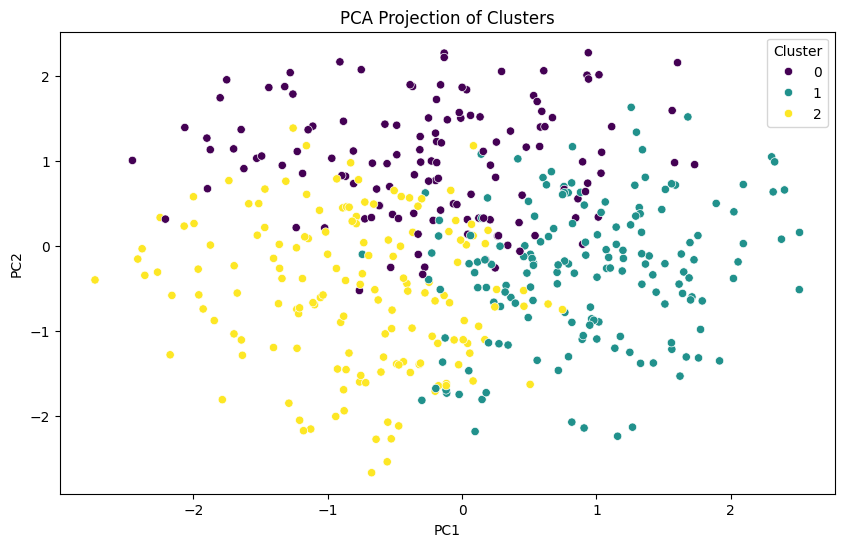

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=data['Cluster'], palette='viridis')
plt.title('PCA Projection of Clusters')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


c:\Users\LJM\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


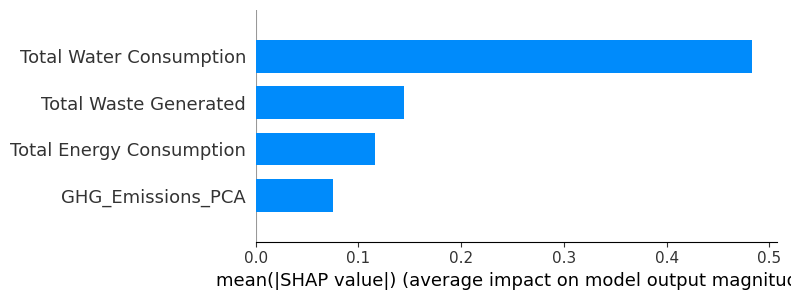

In [7]:
import shap

# Step 8: SHAP Values for Feature Importance
# Calculate SHAP values to understand the impact of each feature
explainer = shap.Explainer(reg, X)
shap_values = explainer(X)

# Summary plot for feature importance
shap.summary_plot(shap_values, X, plot_type="bar")